<a href="https://colab.research.google.com/github/tmdcks1103/Machine-Learning-Programming/blob/main/11%EC%A3%BC%EC%B0%A8/AE_WISDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # 데이터 표준화
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# 데이터 로드
column_names = ['sample_id', 'user_id', 'activity', 'timestamp', 'x_accel', 'y_accel', 'z_accel']
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/11wnck/WISDM.csv', header=None, names=column_names)

print("--- 원본 데이터 ---")
print(df.head())

--- 원본 데이터 ---
   sample_id  user_id activity     timestamp   x_accel    y_accel   z_accel
0          0       33  Jogging  4.910600e+13 -0.694638  12.680544  0.503953
1          1       33  Jogging  4.910610e+13  5.012288  11.264028  0.953424
2          2       33  Jogging  4.910610e+13  4.903325  10.882658 -0.081722
3          3       33  Jogging  4.910620e+13 -0.612916  18.496431  3.023717
4          4       33  Jogging  4.910630e+13 -1.184970  12.108489  7.205164


In [4]:
# 데이터 전처리
features = df.drop(['sample_id', 'user_id', 'timestamp', 'activity'], axis=1)

# 스케일링
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 컬럼명 유지
data = pd.DataFrame(features_scaled, columns=['x_accel', 'y_accel', 'z_accel'])

# 정상/이상 레이블 생성
data['Class'] = df['activity'].apply(lambda x: 0 if x == 'Walking' else 1)
print("\n--- 전처리 완료된 데이터 (스케일링 + Class 생성) ---")
print(data.head())



--- 전처리 완료된 데이터 (스케일링 + Class 생성) ---
    x_accel   y_accel   z_accel  Class
0 -0.221614  0.792210  0.015937      1
1  0.625987  0.580504  0.109693      1
2  0.609804  0.523506 -0.106230      1
3 -0.209476  1.661425  0.541539      1
4 -0.294439  0.706713  1.413753      1


/tmp/ipython-input-3160652758.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data['Class'], sort = True)


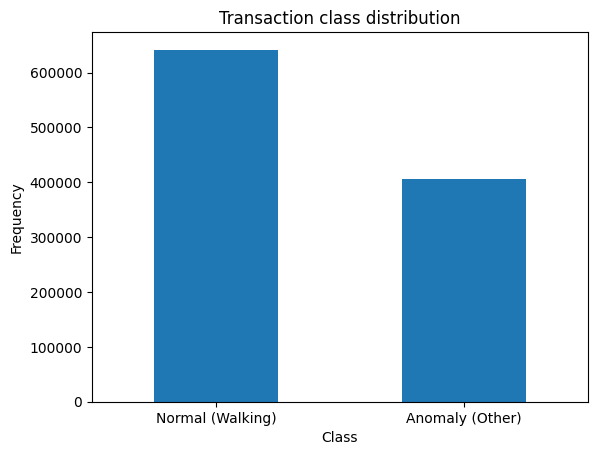

In [18]:
# 클래스 분포 확인
LABELS = ["Normal (Walking)", "Anomaly (Other)"]
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [6]:
# 데이터 분리 (훈련/테스트)
RANDOM_SEED = 42

X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

print(f"\n--- 데이터 분리 결과 ---")
print(f"정상 데이터 훈련 샘플(X_train): {X_train.shape}")
print(f"테스트 피처 샘플(X_test): {X_test.shape}")
print(f"테스트 레이블 샘플(y_test): {y_test.shape}")


--- 데이터 분리 결과 ---
정상 데이터 훈련 샘플(X_train): (325604, 3)
테스트 피처 샘플(X_test): (209715, 3)
테스트 레이블 샘플(y_test): (209715,)


In [8]:
# 오토인코더 모델 정의

input_dim = X_train.shape[1]
encoding_dim = 2

# 모델 구조 설계
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
# 디코더 (2차원 -> 3차원)
decoded = Dense(input_dim, activation='linear')(encoded)

In [9]:
# 모델 생성 및 컴파일
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print("\n--- 오토인코더 모델 요약 ---")
autoencoder.summary()


--- 오토인코더 모델 요약 ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 모델 학습
history = autoencoder.fit(X_train, X_train,
                          epochs=20,
                          batch_size=256,
                          shuffle=True,
                          validation_split = 0.1)

Epoch 1/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6131 - val_loss: 0.2909
Epoch 2/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2636 - val_loss: 0.2034
Epoch 3/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1944 - val_loss: 0.1732
Epoch 4/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1702 - val_loss: 0.1629
Epoch 5/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1610 - val_loss: 0.1591
Epoch 6/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1581 - val_loss: 0.1575
Epoch 7/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1562 - val_loss: 0.1568
Epoch 8/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1565 - val_loss: 0.1564
Epoch 9/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1563 - val_loss: 0.1563
Epoch 10/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1557 - val_loss: 0.1561
Epoch 11/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1557 - val_loss: 0.1559
Epoch 12/20
1145/1145 ━━━━━━━━

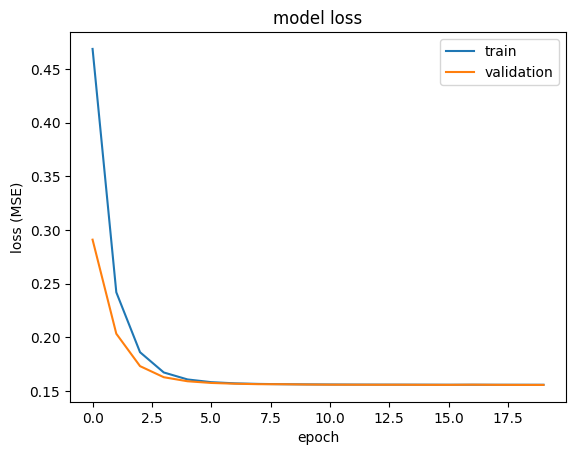

In [19]:
# 학습과정 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [14]:
# 이상 탐지 수행
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)

error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test})

print("\n--- 복원 오차 통계 (전체 테스트 데이터) ---")
print(error_df.describe())
print("\n--- 실제 클래스별 복원 오차 통계 ---")
print(error_df.groupby('true_class')['reconstruction_error'].describe())

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step

--- 복원 오차 통계 (전체 테스트 데이터) ---
       reconstruction_error     true_class
count          2.097150e+05  209715.000000
mean           3.497240e-01       0.612946
std            6.676831e-01       0.487077
min            1.946159e-07       0.000000
25%            2.041389e-02       0.000000
50%            1.073997e-01       1.000000
75%            4.085919e-01       1.000000
max            1.238118e+01       1.000000

--- 실제 클래스별 복원 오차 통계 ---
               count      mean       std           min       25%       50%  \
true_class                                                                   
0            81171.0  0.154248  0.286925  2.449645e-07  0.014150  0.061483   
1           128544.0  0.473160  0.797470  1.946159e-07  0.028064  0.175556   

                 75%        max  
true_class                       
0           0.182934   9.423296  
1           0.613716  12.381178  


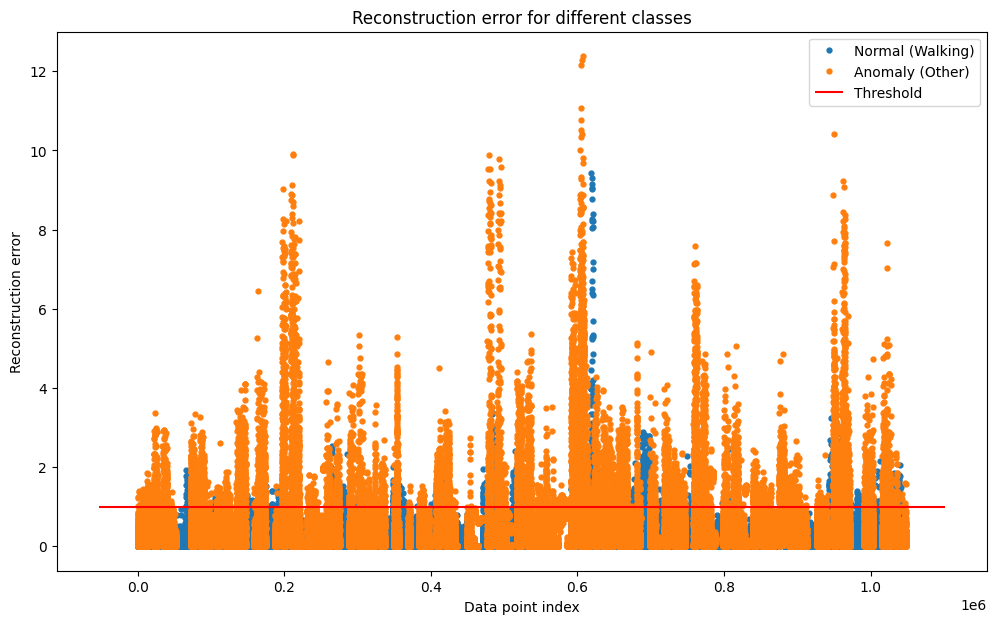

In [20]:
# 임계값 설정 및 시각화
threshold = 1.0

groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(12, 7))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anomaly (Other)" if name == 1 else "Normal (Walking)")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

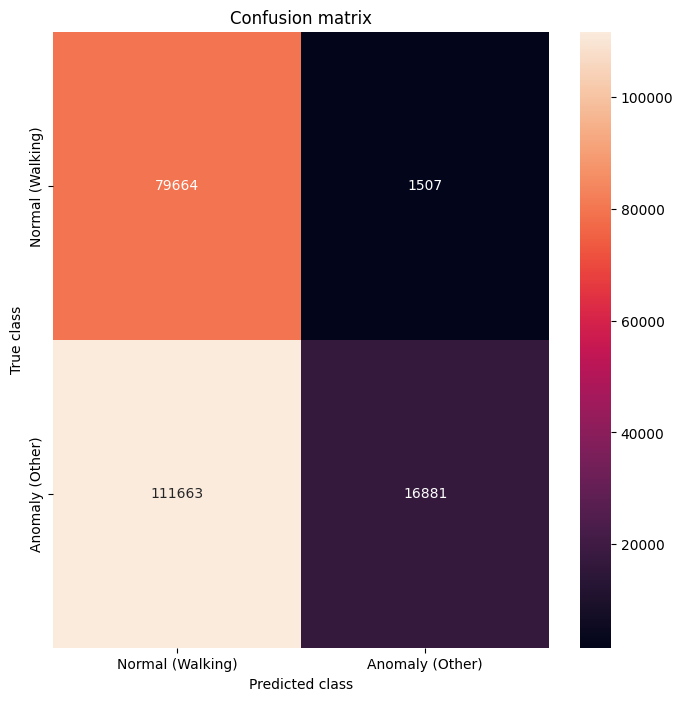


--- 최종 분류 리포트 ---
              precision    recall  f1-score   support

           0       0.42      0.98      0.58     81171
           1       0.92      0.13      0.23    128544

    accuracy                           0.46    209715
   macro avg       0.67      0.56      0.41    209715
weighted avg       0.72      0.46      0.37    209715



In [21]:
# 성능 평가
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]


conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')  # 실제값
plt.xlabel('Predicted class')  # 예측값
plt.show()

print("\n--- 최종 분류 리포트 ---")
print(classification_report(error_df.true_class, y_pred))